In [ ]:
# Import packages
import numpy as np
import cv2

In [ ]:
# Haarcascade classifers
face_classifer = cv2.CascadeClassifier('haarcasacade_frontalface_default.xml')
eye_classifer = cv2.CascadeClassifier('haarcasacade_eye.xml')

In [ ]:
#Input image
image = cv2.imread('sample.jpeg')

In [ ]:
#convert image to gray scale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#face detection
faces = face_classifer.detectMultiScale(gray, 1.3, 5)

#check if zero faces in images

if faces is ():
  print("face not found")

<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-8-ee3b9624373b>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if faces is ():


In [ ]:
def cut_eyebrows(img):
  height, width = img.shape[:2]
  eyebrow_h = int(height / 4)
  img = img[eyebrow_h:height-eyebrow_h, 0:width]  # cut eyebrows out (15 px)
  return img

[[25 37 27 27]
 [69 38 27 27]]


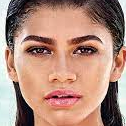

In [ ]:
from google.colab.patches import cv2_imshow
#draw rectangle around eyes

for (x,y,w,h) in faces:
  gray_image = gray[y:y+h, x:x+w]
  color_image = image[y:y+h, x:x+w]
  eyes = eye_classifer.detectMultiScale(gray_image)
  
print(eyes)

boxes = []
for (ex, ey, ew, eh) in eyes:
  boxes.append(color_image[ey:ey+eh, ex:ex+ew])
  #cv2.rectangle(color_image, (ex,ey), (ex+ew, ey + eh), (0,255, 0), 2)

cv2_imshow(color_image)
  
#   cv2.waitKey(0)
# cv2.destroyAllWindows()


for b in boxes:
  cv2_imshow(b)

In [ ]:
corners = []
# get corners
for b in boxes:
  height = b.shape[1]
  corners.append((0, int(height/2)))
  corners.append((height-1, int(height/2)))
print(corners)

[(0, 13), (26, 13), (0, 13), (26, 13)]


In [ ]:
cv2.circle(boxes[0], corners[0], 3, (0, 0, 255), -1)
cv2.circle(boxes[0], corners[1], 3, (0, 0, 255), -1)
cv2_imshow(boxes[0])

cv2.circle(boxes[1], corners[2], 3, (0, 0, 255), -1)
cv2.circle(boxes[1], corners[3], 3, (0, 0, 255), -1)
cv2_imshow(boxes[1])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/MPIIFaceGaze.zip

Streaming output truncated to the last 5000 lines.
  inflating: MPIIFaceGaze/p09/day03/1065.jpg  
  inflating: MPIIFaceGaze/p09/day03/0185.jpg  
  inflating: MPIIFaceGaze/p09/day03/0947.jpg  
  inflating: MPIIFaceGaze/p09/day03/0070.jpg  
  inflating: MPIIFaceGaze/p09/day03/1251.jpg  
  inflating: MPIIFaceGaze/p09/day03/0145.jpg  
  inflating: MPIIFaceGaze/p09/day03/0987.jpg  
  inflating: MPIIFaceGaze/p09/day03/0194.jpg  
  inflating: MPIIFaceGaze/p09/day03/1157.jpg  
  inflating: MPIIFaceGaze/p09/day03/0717.jpg  
  inflating: MPIIFaceGaze/p09/day03/0061.jpg  
  inflating: MPIIFaceGaze/p09/day03/1186.jpg  
  inflating: MPIIFaceGaze/p09/day03/0872.jpg  
  inflating: MPIIFaceGaze/p09/day03/0371.jpg  
  inflating: MPIIFaceGaze/p09/day03/0066.jpg  
  inflating: MPIIFaceGaze/p09/day03/0229.jpg  
  inflating: MPIIFaceGaze/p09/day03/0523.jpg  
  inflating: MPIIFaceGaze/p09/day03/0255.jpg  
  inflating: MPIIFaceGaze/p09/day03/0580.jpg  
  inflating: MPIIFaceGaze/p09/day03/1006.jpg  
  inflati

Loading images of Person p01:
Loaded 1409 total images
Person changes at [0, 1409]
tensor(0., dtype=torch.float64)


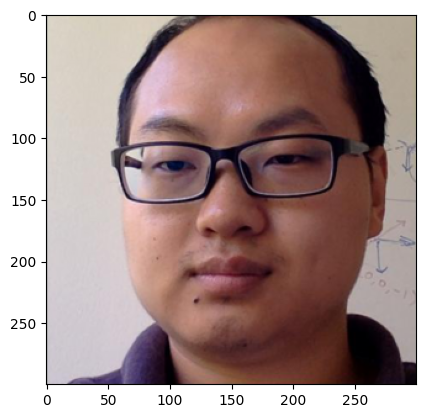

tensor(0., dtype=torch.float64)


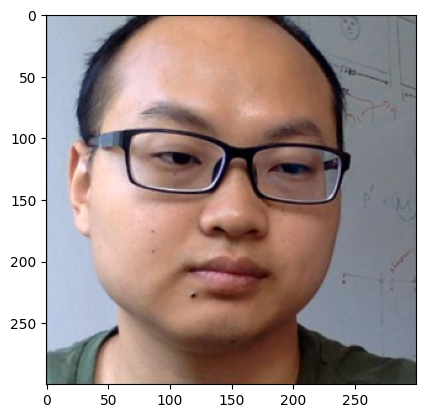

tensor(1., dtype=torch.float64)


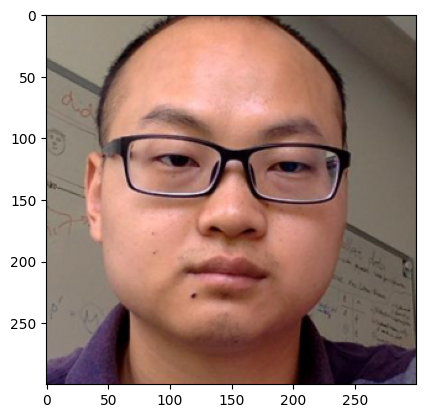

tensor(0., dtype=torch.float64)


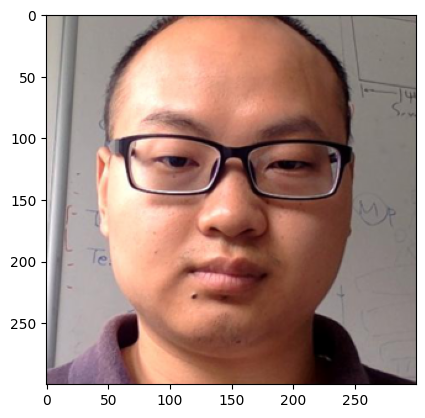

tensor(0., dtype=torch.float64)


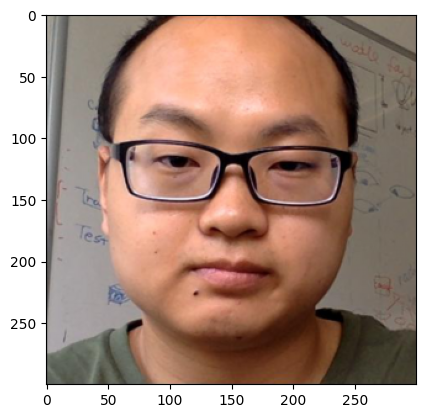

tensor(0., dtype=torch.float64)


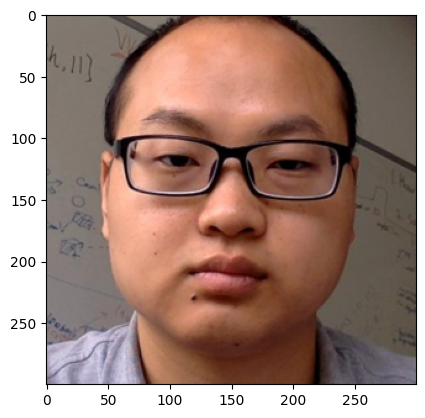

tensor(1., dtype=torch.float64)


KeyboardInterrupt: ignored

In [ ]:
### Imports ###
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os


### Consts ###

data_points = {  # Source: https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/gaze-based-human-computer-interaction/its-written-all-over-your-face-full-face-appearance-based-gaze-estimation#c12823
    'gaze_screen_pos': (0, 2),  # Gaze location on the screen coordinate in pixels
    'eye_pos': (2, 10),         # (x,y) position for the four eye corners
    'mouth_pos': (10, 14),      # (x,y) position for the two mouth corners
    'head_pos': (14, 20),       # The estimated 3D head pose in the camera coordinate system based on 6 points-based
                                # 3D face model, rotation and translation
    'face_center': (20, 23),    # Face center in the camera coordinate system
    'gaze_target': (23, 26)     # The 3D gaze target location in the camera coordinate system
}

base_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((300, 300), antialias=True),])
                                      # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


### Classes ###
#'/content/MPIIFaceGaze'
#data src = '/content/drive/MyDrive/Colab Notebooks/data'
class MPIIFaceGaze(Dataset):
    def __init__(self, img_transform=base_transforms, data_src='/content/drive/MyDrive/Colab Notebooks/data', crop=True,
                 needed_labels=('eye_pos', 'face_center', 'gaze_target'), verbose=False):
        self.img_transform = img_transform
        self.needed_labels = needed_labels
        self.data_src = data_src
        self.crop = crop

        self.images = []
        self.labels = []
        self.person_indexes = [0]
        self.facing_cam = 0.0
        for p in sorted(os.listdir(self.data_src)):
            # Confirm current item is a folder
            person_path = os.path.join(self.data_src, p)
            if not os.path.isdir(person_path):
                continue
            if verbose:
                print(f"Loading images of Person {p}:")

            # Store the labels for the current person
            labels_dict = {}
            f = np.loadtxt(os.path.join(person_path, p + '.txt'), delimiter=' ', dtype=str)
            for d in f:
                labels_dict[os.path.join(p, *d[0].split('/'))] = d[1:-1].astype(np.float32)

            # Loop through each day
            for d in os.listdir(person_path):
                if d[:3] == 'day':
                    day_path = os.path.join(person_path, d)
                    # Gather image paths and associated labels for each image
                    for img in os.listdir(day_path):
                        self.images.append(os.path.join(day_path, img))
                        self.labels.append(labels_dict[os.path.join(p, d, img)])
            self.person_indexes.append(len(self.images))
        if verbose:
            print(f"Loaded {len(self.images)} total images")
            print("Person changes at " + str(self.person_indexes))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        data = np.array(self.labels[index])

        if self.crop:
            # Find the bounds of the faces
            x = np.array(img).sum(axis=2)
            x[x < 60] = 0  # Image boundaries are imprecise
            x = np.nonzero(x)
            img = img.crop((np.min(x[1]), np.min(x[0]), np.max(x[1]), np.max(x[0])))
            # Adjust any labels corresponding to pixel values
            # tried including gaze_pos index
            data[[2, 4, 6, 8, 10, 12]] -= np.min(x[1])
            data[[3, 5, 7, 9, 11, 13]] -= np.min(x[0])

        # Apply image transforms
        if self.img_transform is not None:
            img_size = img.size
            img = self.img_transform(img)

            # Correct data (assuming only resize)
            # changes location of mouth and eye position based on transformation
            # tried including gaze_pos index
            if img.size()[1] != img_size[0]:
                data[[2, 4, 6, 8, 10, 12]] *= img.size()[1]/img_size[0]
            if img.size()[2] != img_size[1]:
                data[[3, 5, 7, 9, 11, 13]] *= img.size()[2]/img_size[1]

        # Collect desired data
        gaze = data[data_points['gaze_target'][0]:data_points['gaze_target'][1]]

        if (gaze[0]*3.779) > -300.0 and (gaze[1]*3.779) < 305.0:
          self.facing_cam = 1.0

        data = np.array([self.facing_cam])
        
        self.facing_cam = 0.0
        # img = img / 255.0

        return img, data


def get_dataloaders(batch_size, dataset=None, split=0.8, shuffle=0, person_val=()):
    # Initialize dataset if not given
    dataset = MPIIFaceGaze() if dataset is None else dataset

    # Collect indices based on if a given person should be included
    train_indices, val_indices = [], []
    for i in range(len(dataset.person_indexes)-1):
        new_indexes = list(range(dataset.person_indexes[i], dataset.person_indexes[i+1]))
        if i in person_val:
            val_indices += new_indexes
        else:
            train_indices += new_indexes

    # Shuffle train indices for different split
    if shuffle:
        np.random.seed(shuffle)
        np.random.shuffle(train_indices)

    # Calculate and perform split on remaining train data
    split = int(split * len(train_indices))
    val_indices += train_indices[split:]
    train_indices = train_indices[:split]

    # Create samplers and associated dataloaders
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

    return train_loader, validation_loader


def crop_eyes(imgs, eye_locs):
    eye_imgs = []
    for face, eyes in zip(imgs, eye_locs.to(torch.int)):
        top = max(min(eyes[1::2]).item() - 20, 0)
        left = max(min(eyes[::2]).item() - 20, 0)
        eye_imgs.append(face[:, top:top + 48, left:left + 160])
    return torch.stack(eye_imgs)


def insert_eyes(imgs, eye_locs, eyes):
    eye_imgs = []
    for face, locs, eye in zip(imgs, eye_locs.to(torch.int), eyes):
        top = max(min(locs[1::2]).item() - 20, 0)
        left = max(min(locs[::2]).item() - 20, 0)
        # face[:, top:top + 48, left:left + 160] = eye
        new_img = torch.cat((face[:, top:top + 48, 0:left], eye, face[:, top:top + 48, left+160:]), dim=2)
        new_img = torch.cat((face[:, 0:top, :], new_img, face[:, top + 48:, :]), dim=1)
        eye_imgs.append(new_img)
    return torch.stack(eye_imgs)


### Run Code ###

if __name__ == "__main__":
    dataset = MPIIFaceGaze(verbose=True)
    # print(dataset[0][1])

    train_data, val_data = get_dataloaders(4, dataset)
    for face, marks in train_data:
        # gets the eye coordinates and gaze target
        facing = marks[0][-1]
        gaze = marks[0:3]
        print(facing)

        # print(np.reshape(gaze_target[0], (-1, 2)).T)
        # will throw an error without the permute part
        plt.imshow(face[0].permute(1, 2, 0))
        # plt.scatter(*np.reshape(e[0], (-1, 2)).T, 5, 'r')
        #plt.scatter(gaze[0][0]*3.779, gaze[0][1]*3.779, 5, 'g')
        plt.show()
        # eyes = crop_eyes(face, marks)
        # # plt.imshow(eyes[0].permute(1, 2, 0))
        # # plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# MODEL
class Gaze(nn.Module):

    def __init__(self):
        super(Gaze, self).__init__()
        ## TODO: define the model
        ## REMEMBER not to change the number of layers nor the number of parameters per layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16 * 149 * 149, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    def forward(self, img):     
        #x is the input that we will give in the network.
        ## TODO: Implement the forward propagation function which will be called everytime during forward pass
        conv1 = self.conv1(img)
        relu1 = self.relu(conv1)
        pool1 = self.pool(relu1)
        pool1 = pool1.view(4, -1)
        # print(pool1.shape)
        fc1 = self.fc1(pool1)
        out = self.relu(fc1)
        return out

In [ ]:
lr = 0.001
epochs = 20
model = Gaze()  #making an instance of the network
optim = torch.optim.Adam(model.parameters(), lr = lr)  #model.paramters() gives all the trainable paramters. 
loss_function = nn.BCELoss()
train_predictions = [] 
val_predictions = []

In [ ]:
for epoch in range(epochs):

    #Training phase
    model.train()  #Setting the model to train phase
    train_loss = []
    val_loss = []
    train_acc = 0.
    val_acc = 0.
    
    for idx, batch in enumerate(train_data):
        inputs, labels = batch
        # print(inputs.shape)
        if (inputs.shape[0] == 4):
          pred = model(inputs)
        else: 
          continue
        #print(pred.shape)
        ## TODO: call loss function
        #print(labels.shape)
        loss = loss_function(pred, labels.float())
        train_predictions.append(pred)
        ## TODO: call backward
        optim.zero_grad()
        loss.backward()
        ## TODO: step optimizer
        optim.step()

        ## TODO: compute accuracy and track accuracy and loss
        train_acc = (pred.round() == labels).float().mean()
        loss = loss.detach()
        train_loss.append(loss)
        

        ## IMPORTANT: don't forget to call zero_grad on the optimizer between batches!!!

    #Validation phase
    model.eval()  #Setting the model to eval mode, hence making it deterministic.
    for idx, batch in enumerate(val_data):
        with torch.no_grad():   #Does not calulate the graidents, as in val phase its not needed. Saves on memory.
            ## TODO: similar to training, but no need to call backward, step, or zero_grad
              inputs, labels = batch
              if (inputs.shape[0] == 4):
                pred = model(inputs)
              else: 
                continue
              loss = loss_function(pred, labels.float())
              val_predictions.append(pred)

              ## TODO: compute accuracy and track accuracy and loss
              val_acc = (pred.round() == labels).float().mean()
              loss = loss.detach()
              val_loss.append(loss)

    # DO NOT change the next two lines
    if epoch%5==0:
        print("Epoch {}, Train loss: {}, Train Acc: {}, Val loss: {}, Val acc: {}".format(epoch, np.mean(train_loss), train_acc, np.mean(val_loss), val_acc))

KeyboardInterrupt: ignored

In [ ]:
#To predict whether someone's eye gaze is looking at the camera as a vector

# train_predictions = torch.cat(train_predictions, dim=0)
# val_predictions = torch.cat(val_predictions, dim=0)
model.eval()  # Set the model to evaluation mode

# Load and preprocess the test image
img_test = base_transforms(image)
test_tensor = torch.tensor(img_test, dtype=torch.float32).unsqueeze(0)  # Add an extra dimension for batch size
print(test_tensor.shape)

# Pass the test image through the model
with torch.no_grad():
    test_pred = model(test_tensor)

# Process the predictions
test_pred_rounded = torch.round(test_pred).detach().cpu().numpy()

print("Test prediction:", test_pred_rounded)


# train_eye_gaze = train_predictions.round().detach().cpu().numpy()
# val_eye_gaze = val_predictions.round().detach().cpu().numpy()

# train_acc = (train_eye_gaze == labels.cpu().numpy()).mean()
# val_acc = (val_eye_gaze == labels.cpu().numpy()).mean()

# print("Epoch {}, Train loss: {}, Train Acc: {}, Val loss: {}, Val acc: {}".format(epoch, np.mean(train_loss), train_acc, np.mean(val_loss), val_acc))


torch.Size([1, 3, 300, 300])


<ipython-input-55-709235783447>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = torch.tensor(img_test, dtype=torch.float32).unsqueeze(0)  # Add an extra dimension for batch size


RuntimeError: ignored